In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from io import StringIO
import os

In [2]:
file = open('/home/helge/Programs/matsim/matsim_results/24h_drt_1percent-bim_19102020/19000reqs/ITERS/it.0/0.occupancyAnalysis.txt', 'r')
data = ""
for x in file:
    if x.startswith('time'):
        match = re.search('.*\t(\d+\.\d+) veh.*(tr_\d+_\d+).*Passenger.*?(\d+)', x)
        if match:
            data += match.group(1) + ";" + match.group(2) + ";" + match.group(3) + "\n"
file.close()

occupancies = pd.read_csv(StringIO(data), names=['time', 'transporter', 'passengers'], sep=';')

In [3]:
occupancies = occupancies.sort_values(by=['transporter', 'time'])

occupancies = occupancies.pivot(index='time', columns='transporter', values='passengers')
new_first_col = pd.DataFrame([[0] * len(occupancies.columns)], columns=occupancies.columns)
occupancies = new_first_col.append(occupancies).fillna(method='ffill')

average_occupancies = occupancies.sum(axis=1)/(10*4*2)
print(len(occupancies.columns))
print(10*4*2)
print(average_occupancies.mean())

# occupancies.to_csv('./data.csv')

480
80
1.053723960810425


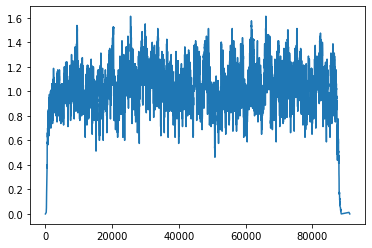

In [4]:
# occupancies.plot(legend=False)
# plt.figure()
average_occupancies.plot()
plt.show()

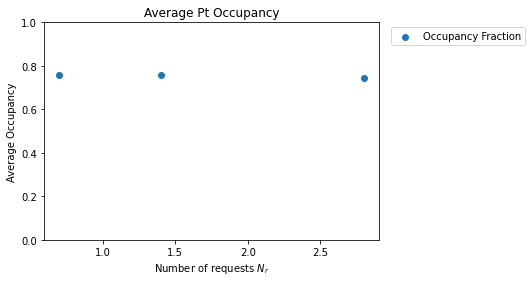

In [3]:
directory_bim = "/home/helge/Programs/matsim/matsim_results/ConvCrit/bim_onewaytransit"

def getPtOccupancies(directory):
    reqs = []
    average_occs = []
    
    for root, subdirs, files in os.walk(directory):
        for file in files:
            if file == '0.occupancyAnalysis.txt':
#                 request = re.match(".*/(\d*)reqs/.*", root)
#                 reqs.append(request.group(1))
                request = re.match(".*gamma(\d*_\d*)", root)
                reqs.append(float(request.group(1).replace('_', '.')))
                data = ""
                file_data = open(os.path.join(root, file))
                for x in file_data:
                    if x.startswith('time'):
                        match = re.search('.*\t(\d+\.\d+) veh.*(tr_\d+_\d+).*Passenger.*?(\d+)', x)
                        if match:
                            data += match.group(1) + ";" + match.group(2) + ";" + match.group(3) + "\n"
                file_data.close()

                occupancies = pd.read_csv(StringIO(data), names=['time', 'transporter', 'passengers'], sep=';')
                occupancies = occupancies.sort_values(by=['transporter', 'time'])

                occupancies = occupancies.pivot(index='time', columns='transporter', values='passengers')
                new_first_col = pd.DataFrame([[0] * len(occupancies.columns)], columns=occupancies.columns)
                occupancies = new_first_col.append(occupancies).fillna(method='ffill')

                average_occupancies = occupancies.sum(axis=1)/len(occupancies.columns)
                average_occs.append(average_occupancies.mean())
                

    reqs = np.array([float(req) for req in reqs])
    average_occupancies = np.array(average_occs)

    return reqs, average_occupancies
 

reqs_bim, av_occupancies_bim = getPtOccupancies(directory_bim)
plt.scatter(reqs_bim, av_occupancies_bim/10, label=r"Occupancy Fraction")
# plt.xlabel(r"Number of requests $N_r$")
plt.ylabel(r"Average Occupancy")
plt.ylim(0, 1)
plt.title('Average Pt Occupancy')
lgd = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.savefig("AveragePtOccupany.png", bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()